# Inverting the Lens Equation

The lens equation $\vec{\beta} = \vec{\theta} - \vec{\alpha}(\vec{\theta})$ allows us to find a point in the source plane given a point in the image plane. However, sometimes we know a point in the source plane and would like to see where it ends up in the image plane. This is not easy to do since a point in the source plane may map to multiple locations in the image plane. There is no closed form function to invert the lens equation, in large part because the deflection angle $\vec{\alpha}$ depends on the position in the image plane $\vec{\theta}$. To invert the lens equation, we will need to rely on optimization and a little luck to find all the images for a given source plane point. Below we will demonstrate how this is done in caustic!

In [1]:
%load_ext autoreload
%autoreload 2

from functools import partial 

import torch
from torch.nn.functional import avg_pool2d
import matplotlib.pyplot as plt
from ipywidgets import interact
from astropy.io import fits
import numpy as np

import caustic

In [2]:
# initialization stuff for an SIE lens

cosmology = caustic.FlatLambdaCDM(name = "cosmo")
cosmology.to(dtype=torch.float32)
n_pix = 100
res = 0.05
upsample_factor = 2
fov = res * n_pix
thx, thy = caustic.get_meshgrid(res/upsample_factor, upsample_factor*n_pix, upsample_factor*n_pix, dtype=torch.float32)
z_l = torch.tensor(0.5, dtype=torch.float32)
z_s = torch.tensor(1.5, dtype=torch.float32)
lens = caustic.SIE(
    cosmology = cosmology, 
    name = "sie",
    z_l = z_l,
    x0 = torch.tensor(0.),
    y0 = torch.tensor(0.),
    q = torch.tensor(0.4),
    phi = torch.tensor(np.pi/5),
    b = torch.tensor(1.),
)

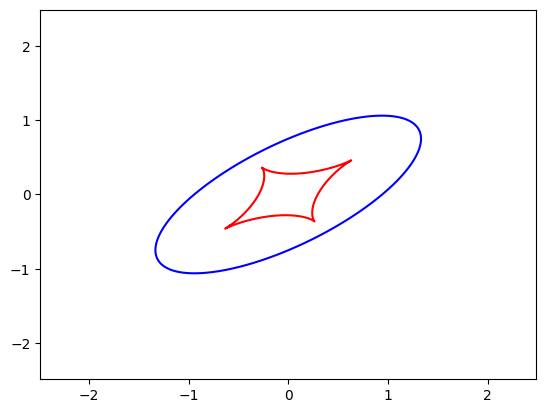

In [3]:
# For the sake of visualization, we will show the critical lines. If you want to know more, see the "VisualizeCaustics.ipynb" tutorial

J = lens.jacobian_reduced_deflection_angle(thx, thy, z_s)

A = torch.eye(2) - J
detA = torch.linalg.det(A)

fig, ax = plt.subplots()

CS = ax.contour(thx, thy, detA, levels = [0.], colors = "b")
# Get the path from the matplotlib contour plot of the critical line
paths = CS.collections[0].get_paths()
caustic_paths = []
for path in paths:
    # Collect the path into a descrete set of points
    vertices = path.interpolated(5).vertices
    x1 = torch.tensor(list(float(vs[0]) for vs in vertices))
    x2 = torch.tensor(list(float(vs[1]) for vs in vertices))
    # raytrace the points to the source plane
    y1,y2 = lens.raytrace(x1, x2, z_s)

    # Plot the caustic
    ax.plot(y1,y2, color = "r")
plt.show()

In [5]:
# Point in the source plane
sp_x = torch.tensor((0.2, -1)).reshape(2)
sp_y = torch.tensor((0.2, -1)).reshape(2)
print(sp_x.shape, sp_y.shape)
res = caustic.forward_raytrace(
    sp_x, 
    sp_y, 
    lambda x, y: torch.stack(lens.reduced_deflection_angle(x, y, z_s = z_s)), 
    n_images = 4,
    thetax_range = (-fov/2, fov/2),
    thetay_range = (-fov/2, fov/2),
)

torch.Size([2]) torch.Size([2])
torch.Size([15, 2]) torch.Size([15, 2, 2])


RuntimeError: The size of tensor a (2) must match the size of tensor b (15) at non-singleton dimension 1